In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from numpy import zeros
from pickle import dump
#from os import chdir

In [2]:
# Loading custom defined functions
#wd = open('wd.cfg').read()
#chdir(wd)
from tokenization import tokenize_sentence_nltk#, tokenize_treetagger
from util import read_file, flatten_list_of_list#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, clean_strings
from pos_tagging import run_treetagger_pos_tag_text
from modeling import run_word2vec_model, apply_bigram_trigram_model
from modeling import run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
DetectorFactory.seed = 0

# Testing language
in_file = open("in_file.cfg").read()
in_file = in_file.split("\n")
label = in_file[3]
col = in_file[2]
in_type = in_file[1]
in_file = in_file[0]
strings = read_file(in_file, in_type = in_type)
if(in_type == "text"):
    strings = tokenize_sentence_nltk(strings)
    strings = DataFrame(strings)[0]
else:
    if(label in strings.columns):
        labels = strings[label]
    strings = strings[col]

strings = strings.apply(clean_strings)
languages = strings.apply(detect_language)

In [4]:
# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

In [5]:
# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
labels = labels[english_only].tolist()

In [6]:
# Processing English sentences:
# 1) Splitting sentences
sentences = strings.apply(tokenize_sentence_nltk)
lengths = sentences.apply(len).tolist()
new_labels = []
for i in range(len(lengths)):
    for j in range(lengths[i]):
        new_labels.append(labels[i])
new_labels = Series(new_labels)
sentences1 = flatten_list_of_list(sentences)

In [7]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = Series(sentences1)
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

In [8]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

In [9]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

In [10]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+i if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
sentences1 = sentences1 + inc_sentences.tolist()
labels = labels.tolist() + inc_labels.tolist()

In [11]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")
out_file.close()

In [14]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

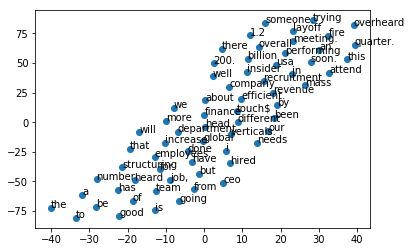

In [17]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

In [18]:
# 9) Setting up the data for building logistic regression model
df = zeros((len(sentences1), 100))
for i, words in enumerate(trigrams):
    for word in words:
        try:
            df[i] = df[i] + model[word]
        except:
            continue

while(i<len(sentences1)):
    i += 1

df = DataFrame(df)
df[label] = labels

In [19]:
# 10) Building and saving the logistic regression model with L1 penalty
lr_model = build_logistic_regression(df, label)
dump(lr_model, open("logistic_model.pkl", 'wb'))

In [26]:
# 11) Topic modeling (Optional)
lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
for i in range(3):
    print(lda_model.print_topic(i+1))

0.025*"ceo" + 0.025*"trying" + 0.025*"fire" + 0.025*"someone" + 0.025*"overheard" + 0.024*"done" + 0.024*"good" + 0.024*"needs" + 0.024*"well" + 0.024*"quarter"
0.024*"needs" + 0.024*"mass" + 0.024*"team" + 0.024*"performing" + 0.024*"well" + 0.024*"quarter" + 0.024*"done" + 0.024*"good" + 0.024*"job" + 0.024*"attend"
0.025*"increase" + 0.025*"200." + 0.025*"number" + 0.025*"employees" + 0.025*"going" + 0.025*"recruitment" + 0.025*"done" + 0.025*"good" + 0.025*"heard" + 0.025*"job"


In [41]:
from gensim import corpora
texts = open("sample_cleaned.txt", "r").read().split("\n")
texts = [text.split(" ") for text in texts]
dictionary = corpora.Dictionary(texts)
for i in range(4):
    text = dictionary.doc2bow(texts[i])
    print(lda_model.get_document_topics(bow = text))


[(31, 0.55666666666666753), (34, 0.33444444444444488)]
[(34, 0.36454545454545501), (42, 0.54636363636363705)]
[(7, 0.20146638320828977), (31, 0.16722222222222194), (34, 0.056111111111111021), (42, 0.11166666666666648), (58, 0.18853361679170963), (71, 0.22277777777777741)]
[(7, 0.056111111111111042), (31, 0.22277777777777749), (34, 0.11166666666666653), (41, 0.16722222222222199), (42, 0.11166666666666653), (58, 0.11166666666666653), (71, 0.056111111111111042), (79, 0.11166666666666653)]
